# 1. Исследовательский анализ данных

Загрузим данные.

In [1]:
import pandas as pd
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим на распределение возраста в выборке.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39eefb0790>]],
      dtype=object)

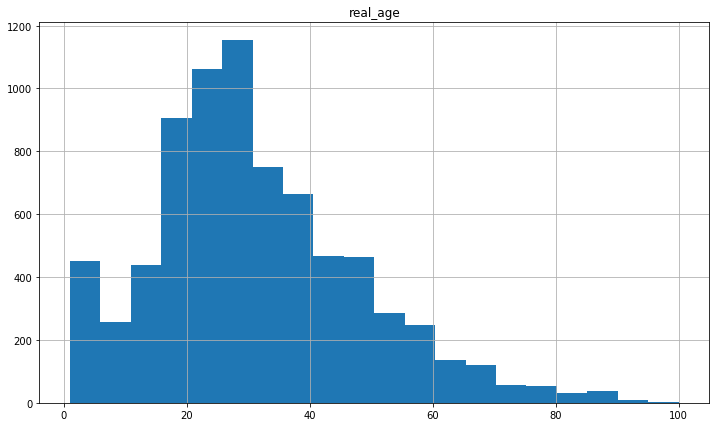

In [2]:
labels.hist(bins=20,figsize=(12,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39984c9590>]],
      dtype=object)

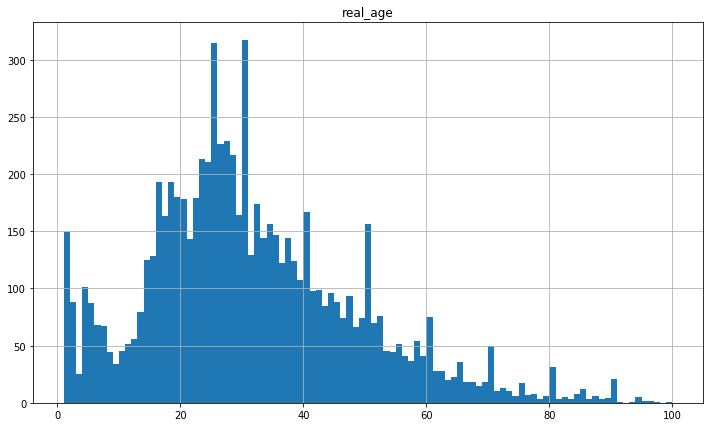

In [7]:
labels.hist(bins=99,figsize=(12,7))

In [3]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Распределение возраста близкое к нормальному, со средним и медианным возрастом в диапозоне от 29-31 года.

Загрузим изображения.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


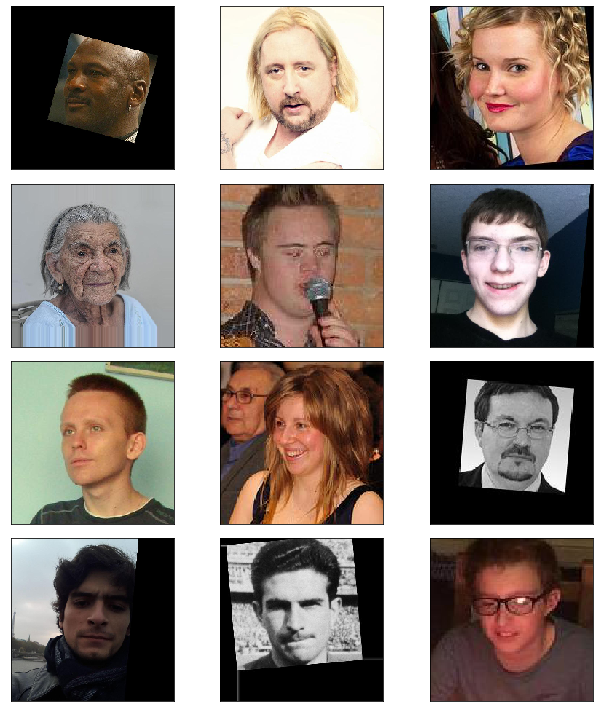

In [6]:
features, target = next(datagen_flow)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

В данных качество фотографий достаточно низкое, большой возрастной диапозон и небольшое количество фотографий с каждым конкретным возрастом. Для решения задачи нужно использовать предобученную сеть с архитектурой ResNet.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

356/356 - 50s - loss: 209.6382 - mae: 11.0582 - val_loss: 325.0263 - val_mae: 13.3622
Epoch 2/20
356/356 - 41s - loss: 137.7151 - mae: 8.9531 - val_loss: 215.6783 - val_mae: 11.0175
Epoch 3/20
356/356 - 41s - loss: 110.2044 - mae: 8.0126 - val_loss: 327.0749 - val_mae: 14.0841
Epoch 4/20
356/356 - 40s - loss: 97.1534 - mae: 7.5073 - val_loss: 111.4538 - val_mae: 8.4339
Epoch 5/20
356/356 - 41s - loss: 79.7861 - mae: 6.8002 - val_loss: 188.8958 - val_mae: 10.2447
Epoch 6/20
356/356 - 41s - loss: 73.3941 - mae: 6.5470 - val_loss: 102.6260 - val_mae: 7.6104
Epoch 7/20
356/356 - 41s - loss: 57.6773 - mae: 5.8426 - val_loss: 103.6968 - val_mae: 7.9310
Epoch 8/20
356/356 - 41s - loss: 52.2608 - mae: 5.5500 - val_loss: 88.2120 - val_mae: 6.9864
Epoch 9/20
356/356 - 41s - loss: 42.1828 - mae: 4.9656 - val_loss: 124.8249 - val_mae: 8.9073
Epoch 10/20
356/356 - 41s - loss: 36.5893 - mae: 4.6918 - val_loss: 91.3850 - val_mae: 7.2098
Epoch 11/20
356/356 - 41s - loss: 33.1042 - mae: 4.4358 - val_loss: 93.0265 - val_mae: 7.3984
Epoch 12/20
356/356 - 41s - loss: 32.0670 - mae: 4.3479 - val_loss: 85.8900 - val_mae: 6.9937
Epoch 13/20
356/356 - 40s - loss: 26.4475 - mae: 3.9766 - val_loss: 91.2528 - val_mae: 7.1535
Epoch 14/20
356/356 - 41s - loss: 23.1861 - mae: 3.7071 - val_loss: 91.0222 - val_mae: 7.1036
Epoch 15/20
356/356 - 41s - loss: 21.5697 - mae: 3.5605 - val_loss: 92.1045 - val_mae: 7.1310
Epoch 16/20
356/356 - 41s - loss: 20.4350 - mae: 3.4976 - val_loss: 83.6268 - val_mae: 6.9450
Epoch 17/20
356/356 - 41s - loss: 18.1935 - mae: 3.2793 - val_loss: 88.2969 - val_mae: 6.9836
Epoch 18/20
356/356 - 41s - loss: 20.9500 - mae: 3.5464 - val_loss: 87.1764 - val_mae: 7.1461
Epoch 19/20
356/356 - 41s - loss: 17.7064 - mae: 3.2546 - val_loss: 84.2962 - val_mae: 6.8378
Epoch 20/20
356/356 - 41s - loss: 16.1544 - mae: 3.1194 - val_loss: 88.8062 - val_mae: 6.9324

```

# 3. Анализ обученной модели

На валидационной выборке удалось получить значение MAE равное 9.9324.